In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

### Reading Dataset

In [2]:
dataset = pd.read_csv("HR-Employee.csv")

In [3]:
dataset.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
dataset.shape

(1470, 35)

### Exploratory Data Analysis

<AxesSubplot:xlabel='Attrition', ylabel='count'>

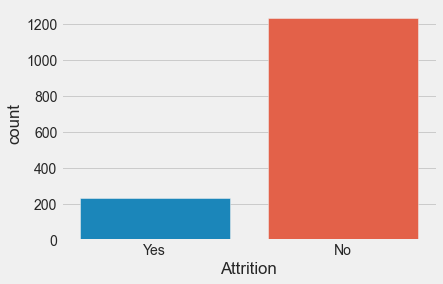

In [7]:
sns.countplot(x='Attrition', data=dataset)

In [8]:
dataset.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis="columns", inplace=True)

In [9]:
categorical_col = []
for column in dataset.columns:
    if dataset[column].dtype == object and len(dataset[column].unique()) <= 50:
        categorical_col.append(column)

In [10]:
dataset['Attrition'] = dataset.Attrition.astype("category").cat.codes

### Data Processing

In [11]:
categorical_col.remove('Attrition')

In [12]:
categorical_col

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime']

In [13]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for column in categorical_col:
    dataset[column] = label.fit_transform(dataset[column])

In [14]:
from sklearn.model_selection import train_test_split

X = dataset.drop('Attrition', axis=1)
y = dataset.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

### Utility functions for Performance Analysis

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(model, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = model.predict(X_train)
        model_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n==================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("------------------------------------")
        print(f"Classification Report:\n{model_report}")
        print("------------------------------------")
        print(f"Confusion Matrix:\n {confusion_matrix(y_train, pred)}\n")
    
    elif train==False:
        pred=model.predict(X_test)
        model_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n====================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("------------------------------------")
        print(f"Classification Report:\n{model_report}")
        print("------------------------------------")
        print(f"Confusion Matrix:\n{confusion_matrix(y_test, pred)}\n")

In [16]:
model_performance = []
def add_model_performance(model_name, model, X_test, y_test):
    pred = model.predict(X_test)
    model_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
    accuracy = round(accuracy_score(y_test, pred) * 100, 2)
    model_performance.append((model_name,accuracy))

### 1. Decision Tree Classifier

In [17]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

print_score(tree_model, X_train, y_train, X_test, y_test, train=True)
print_score(tree_model, X_train, y_train, X_test, y_test, train=False)

add_model_performance('Decision Tree', tree_model, X_test, y_test)

Train Result:
Accuracy Score: 100.00%
------------------------------------
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
------------------------------------
Confusion Matrix:
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 77.78%
------------------------------------
Classification Report:
                    0          1  accuracy   macro avg  weighted avg
precision    0.887363   0.259740  0.777778    0.573551      0.800549
recall       0.850000   0.327869  0.777778    0.588934      0.777778
f1-score     0.868280   0.289855  0.777778    0.579067      0.788271
support    380.000000  61.000000  0.777778  441.000000    441.000000
------------------------------------
Confusion Matrix:
[[323  57]
 [ 41  20]]



### 2. Decision Tree Classifier Hyperparameter tuning

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

params = { 
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"),
    "max_depth":(list(range(1, 20))),
    "min_samples_split":[2, 3, 4], 
    "min_samples_leaf":list(range(1, 20)),
}

tree_model2 = DecisionTreeClassifier(random_state=42)
tree_cv = GridSearchCV(tree_model2, params, scoring="accuracy", n_jobs=-1, verbose=1, cv=3)
tree_cv.fit(X_train, y_train)
best_params = tree_cv.best_params_
print(f"Best parameters: {best_params}")

tree_model2 = DecisionTreeClassifier(**best_params)
tree_model2.fit(X_train, y_train)

print_score(tree_model2, X_train, y_train, X_test, y_test, train=True)
print_score(tree_model2, X_train, y_train, X_test, y_test, train=False)
add_model_performance('Decision Tree Tuned', tree_model2, X_test, y_test)

Fitting 3 folds for each of 4332 candidates, totalling 12996 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
Train Result:
Accuracy Score: 88.82%
------------------------------------
Classification Report:
                    0           1  accuracy    macro avg  weighted avg
precision    0.906388    0.752066  0.888241     0.829227      0.879993
recall       0.964830    0.517045  0.888241     0.740938      0.888241
f1-score     0.934696    0.612795  0.888241     0.773745      0.879638
support    853.000000  176.000000  0.888241  1029.000000   1029.000000
------------------------------------
Confusion Matrix:
 [[823  30]
 [ 85  91]]

Test Result:
Accuracy Score: 84.35%
------------------------------------
Classification Report:
                    0          1  accuracy   macro avg  weighted avg
precision    0.887781   0.400000  0.843537    0.643890      0.820310
recall       0.936842   0.262295  0.843537

### Visualization of a tree

In [19]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

features = list(dataset.columns)
features.remove("Attrition")

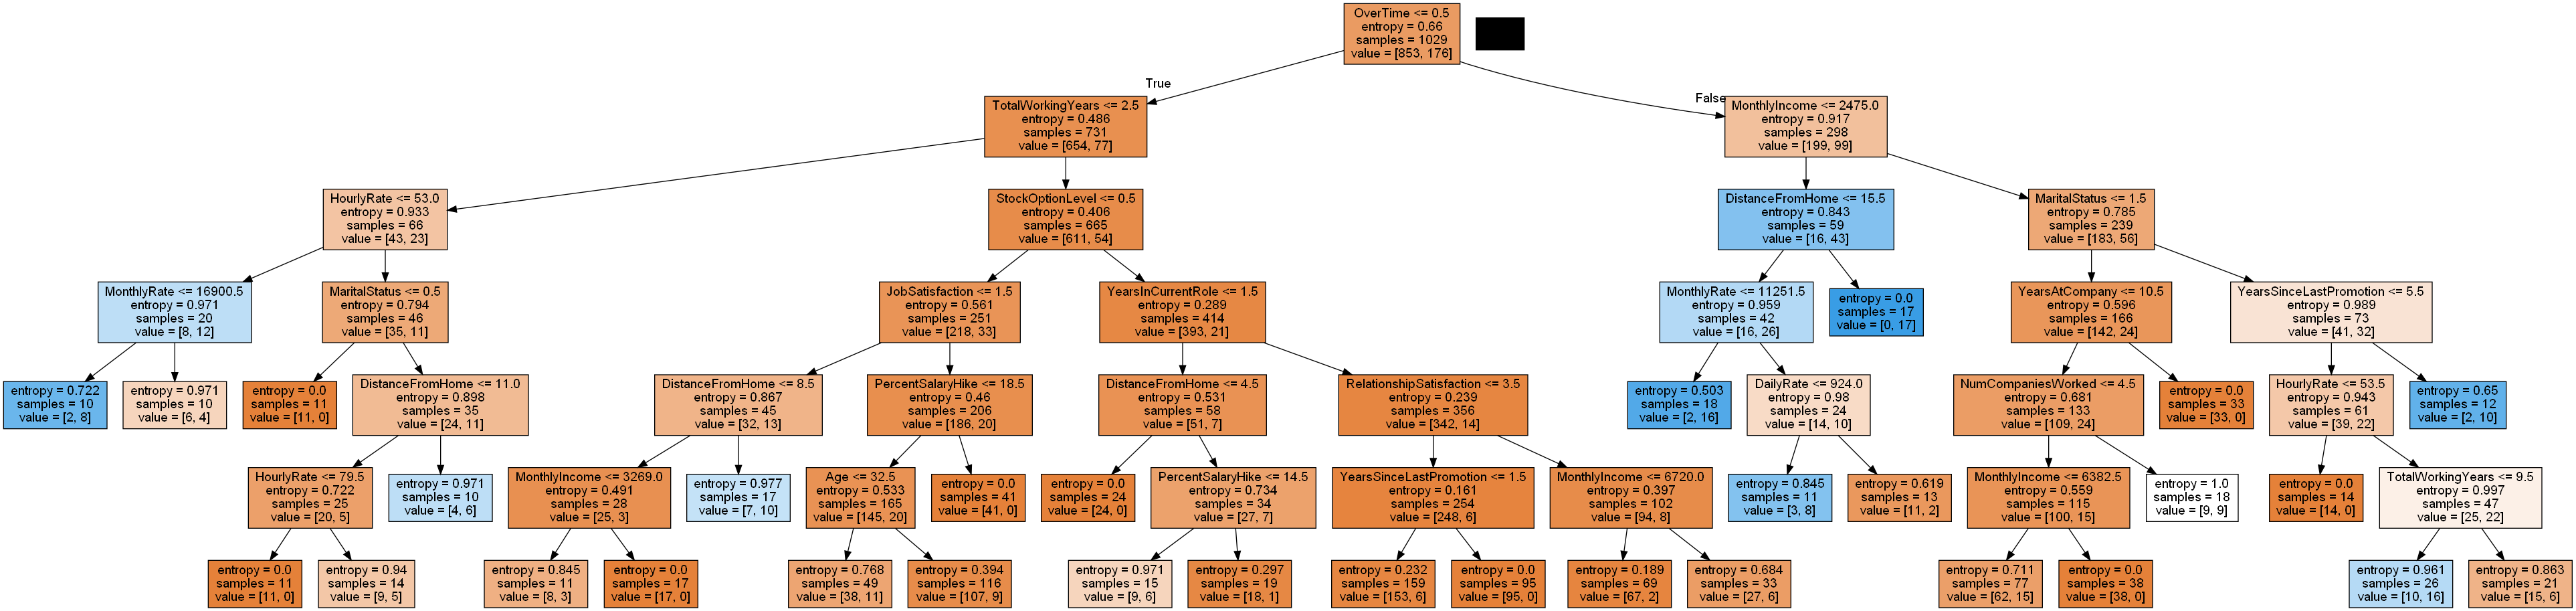

In [20]:
dot_data = StringIO()
export_graphviz(tree_model2, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

### 3. Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

print_score(rf_model, X_train, y_train, X_test, y_test, train=True)
print_score(rf_model, X_train, y_train, X_test, y_test, train=False)
add_model_performance('Random Forest', rf_model, X_test, y_test)

Train Result:
Accuracy Score: 100.00%
------------------------------------
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
------------------------------------
Confusion Matrix:
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 86.62%
------------------------------------
Classification Report:
                    0          1  accuracy   macro avg  weighted avg
precision    0.872390   0.600000  0.866213    0.736195      0.834712
recall       0.989474   0.098361  0.866213    0.543917      0.866213
f1-score     0.927250   0.169014  0.866213    0.548132      0.822370
support    380.000000  61.000000  0.866213  441.000000    441.000000
------------------------------------
Confusion Matrix:
[[376   4]
 [ 55   6]]



### 4. Random Forest hyperparameter tuning

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_model2 = RandomForestClassifier(random_state=42)

rf_cv = RandomizedSearchCV(estimator=rf_model2, scoring='f1', param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

rf_cv.fit(X_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best parameters: {rf_best_params}")

rf_model2 = RandomForestClassifier(**rf_best_params)
rf_model2.fit(X_train, y_train)

print_score(rf_model2, X_train, y_train, X_test, y_test, train=True)
print_score(rf_model2, X_train, y_train, X_test, y_test, train=False)
add_model_performance('Random Forest Tuned', rf_model2, X_test, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90, 'bootstrap': False}
Train Result:
Accuracy Score: 100.00%
------------------------------------
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
------------------------------------
Confusion Matrix:
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 86.17%
------------------------------------
Classification Report:
                    0          1  accuracy   macro avg  weighted avg
precision    0.871795   0.500000  0.861678    0.685897      0.820367
recall       0.984211   0.098361  0.861678    0.541286      0.861678
f1-score     0

### 5. AdaBoost 

In [23]:
from sklearn.ensemble import AdaBoostClassifier

ab_model = AdaBoostClassifier()
ab_model.fit(X_train, y_train)

print_score(ab_model, X_train, y_train, X_test, y_test, train=True)
print_score(ab_model, X_train, y_train, X_test, y_test, train=False)
add_model_performance('AdaBoost', ab_model, X_test, y_test)

Train Result:
Accuracy Score: 90.57%
------------------------------------
Classification Report:
                    0           1  accuracy    macro avg  weighted avg
precision    0.911765    0.855856  0.905734     0.883810      0.902202
recall       0.981243    0.539773  0.905734     0.760508      0.905734
f1-score     0.945229    0.662021  0.905734     0.803625      0.896789
support    853.000000  176.000000  0.905734  1029.000000   1029.000000
------------------------------------
Confusion Matrix:
 [[837  16]
 [ 81  95]]

Test Result:
Accuracy Score: 86.39%
------------------------------------
Classification Report:
                    0          1  accuracy   macro avg  weighted avg
precision    0.900000   0.512195  0.863946    0.706098      0.846358
recall       0.947368   0.344262  0.863946    0.645815      0.863946
f1-score     0.923077   0.411765  0.863946    0.667421      0.852351
support    380.000000  61.000000  0.863946  441.000000    441.000000
---------------------------

### 6. Gradient Boosting

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gb_model.fit(X_train, y_train)

print_score(gb_model, X_train, y_train, X_test, y_test, train=True)
print_score(gb_model, X_train, y_train, X_test, y_test, train=False)
add_model_performance('Gradient Boost', gb_model, X_test, y_test)

Train Result:
Accuracy Score: 91.64%
------------------------------------
Classification Report:
                    0           1  accuracy    macro avg  weighted avg
precision    0.920044    0.887931  0.916424     0.903987      0.914551
recall       0.984760    0.585227  0.916424     0.784993      0.916424
f1-score     0.951302    0.705479  0.916424     0.828391      0.909257
support    853.000000  176.000000  0.916424  1029.000000   1029.000000
------------------------------------
Confusion Matrix:
 [[840  13]
 [ 73 103]]

Test Result:
Accuracy Score: 87.76%
------------------------------------
Classification Report:
                    0          1  accuracy   macro avg  weighted avg
precision    0.907500   0.585366  0.877551    0.746433      0.862942
recall       0.955263   0.393443  0.877551    0.674353      0.877551
f1-score     0.930769   0.470588  0.877551    0.700679      0.867116
support    380.000000  61.000000  0.877551  441.000000    441.000000
---------------------------

### 7. XGBoost

In [27]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

print_score(xgb_model, X_train, y_train, X_test, y_test, train=True)
print_score(xgb_model, X_train, y_train, X_test, y_test, train=False)
add_model_performance('XGB Boost', xgb_model, X_test, y_test)

Train Result:
Accuracy Score: 100.00%
------------------------------------
Classification Report:
               0      1  accuracy  macro avg  weighted avg
precision    1.0    1.0       1.0        1.0           1.0
recall       1.0    1.0       1.0        1.0           1.0
f1-score     1.0    1.0       1.0        1.0           1.0
support    853.0  176.0       1.0     1029.0        1029.0
------------------------------------
Confusion Matrix:
 [[853   0]
 [  0 176]]

Test Result:
Accuracy Score: 85.71%
------------------------------------
Classification Report:
                    0          1  accuracy   macro avg  weighted avg
precision    0.885645   0.466667  0.857143    0.676156      0.827691
recall       0.957895   0.229508  0.857143    0.593701      0.857143
f1-score     0.920354   0.307692  0.857143    0.614023      0.835609
support    380.000000  61.000000  0.857143  441.000000    441.000000
------------------------------------
Confusion Matrix:
[[364  16]
 [ 47  14]]



In [36]:
df = pd.DataFrame(model_performance)
df.columns = ['Classifier', 'Accuracy(%)'] 

In [37]:
df

,Classifier,Accuracy(%)
0,Decision Tree,77.78
1,Decision Tree Tuned,84.35
2,Random Forest,86.62
3,Random Forest Tuned,86.17
4,AdaBoost,86.39
5,Gradient Boost,87.76
6,XGB Boost,85.71


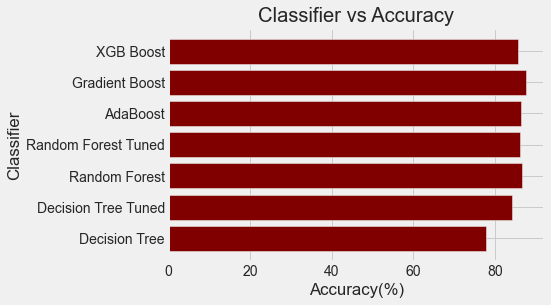

In [44]:
plt.barh(df['Classifier'],df['Accuracy(%)'], color ='maroon')
plt.xlabel("Accuracy(%)")
plt.ylabel("Classifier")
plt.title("Classifier vs Accuracy")
plt.show()

### Summary:

Tree-based Machine Learning is distinguished into 4 complexity levels. The simplest model is the **Decision Tree**. A combination of Decision Trees builds a **Random Forest**. Random Forest usually has higher accuracy than Decision Tree does. A group of Decision Trees built one after another by learning their predecessor is **Adaptive Boosting** and **Gradient Boosting** Machine. Adaptive and Gradient Boosting Machine can perform with better accuracy than Random Forest can. **Extreme Gradient Boosting** is created to compensate for the overfitting problem of Gradient Boosting.

From the above analysis we can see Decision Tree has lowest Accuracy as it is the simplest model. Similarly Random Forest has higher accuracy than decision tree as it is the combination of decision trees. Adaptive Boosting has slightly higher accuracy than Random forest and Gradient Boosting has the highest accuracy among all model. Gradient Boosting has the weakness of overfitting and XGBoost is designed as a regularized Gradient Boosting to reduce the overfitting problem. But in this case we can see Gradient Boosting is doing well in comparision to all other tree based model.

Thus, we can say that for above dataset Gradient Boosting has the best accuracy amongst all tree-based algorithms.